## Spam Classification
In this notebook we demonstrate how to classify if an image is SPAM or HAM using the SMS Spam Collection Dataset which can be found [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset#spam.csv)


In [1]:
!pip install fastai==1.0.60

     |████████████████████████████████| 245kB 5.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=d7ab8a16d1666c059ec7f19af012864902772bdfab299f582dfb6f2eff9aa6a1
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import pandas as pd
import wget
import os
from zipfile import ZipFile

In [4]:
try :
    from google.colab import files 
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'          
    file = ZipFile(temp)           
    file.extractall(path)          
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2021-06-04 06:42:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   774KB/s    in 0.3s    

2021-06-04 06:42:35 (774 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [5]:
import fastai
from fastai import *
from fastai.text import *
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [6]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_train, df_test = train_test_split(df,stratify = df['target'], test_size = 0.2, random_state = 2020)

In [9]:
df_train.shape,df_test.shape

((4457, 2), (1115, 2))

In [10]:
# Language model data 
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "")  

# Classifier model data 
data_class = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [11]:
df_test

,target,text
3815,ham,Can. Dunno wat to get 4 her...
399,ham,"Good evening Sir, Al Salam Wahleykkum.sharing ..."
4778,ham,Sorry completely forgot * will pop em round th...
2319,ham,On the way to office da..
211,ham,"What's up bruv, hope you had a great break. Do..."
...,...,...
3752,ham,"Haha... Sounds crazy, dunno can tahan anot..."
5130,ham,Any way where are you and what doing.
5306,ham,Ill be at yours in about 3 mins but look out f...
5314,spam,Get the official ENGLAND poly ringtone or colo...


TextLMDataBunch applies some text preprocessing tasks to help the algorithm perform better. Altough we commonly remove stoopwords and punctuations, here we do not do it. This model can handle semantics, deleting such information might do more harm than good with respect to accuracy

Now lets look at our training data


In [12]:
data_lm.show_batch()

idx,text
0,". xxmaj mark is taking forever to pick up my prescription and the pain is coming back . xxbos xxmaj your credits have been xxunk up for http : / / xxunk xxmaj your renewal xxmaj pin is xxunk xxbos xxmaj loan for any purpose £ 500 - £ 75,000 . xxmaj homeowners + xxmaj tenants welcome . xxmaj have you been previously refused ? xxmaj we can still help"
1,"b going to esplanade fr home ? xxbos somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true ... goodnite & & sweet dreams xxbos xxmaj well that must be a pain to catch xxbos sry ca n't talk on phone , with parents xxbos xxmaj hope you are having a good week . xxmaj just checking in xxbos"
2,"on a xxup reality xxup fantasy xxup show call now = 08707509020 xxmaj just 20p per min xxup ntt xxmaj ltd , xxup po xxmaj box 1327 xxmaj croydon xxup cr9 xxup 5wb 0870 is a national = rate call xxbos i think your xxunk is , but not 100 xxunk sure . xxbos xxmaj all e best 4 ur driving tmr :-) xxbos xxmaj finished class where are you"
3,"is * rite u put xxunk 10 xxunk mnth is that all ? xxbos xxmaj have you been xxunk your xxunk ? xxbos xxmaj what year . xxmaj and how many miles . xxbos , how 's things ? xxmaj just a quick question . xxbos xxmaj tell your friends what you plan to do on xxmaj valentines day @ < xxup url > xxbos * xxmaj was really good"
4,message . xxmaj this is a final contact attempt . xxmaj you have important messages waiting out our customer claims xxunk . xxmaj expires 13 / 4 / 04 . xxmaj call xxunk xxup now ! xxbos xxmaj miles and smiles r made frm same letters but do u know d difference .. ? smile on ur face keeps me happy even though i am miles away from u ..


Those 'xxmaj','xxbos', 'xxup' etc are all special tokens for the NN. xxbos stands for begin of sentence, xxmaj indicates that the first letter of the next word is in capital letter, 'xxup' is used to indicate the entire  next word is in captital letters. You can view the entire set of tokens [here.](https://docs.fast.ai/text.transform.html)

In [13]:
model = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.5)

We will use a pretrained model. You can learn more about it [here.](https://docs.fast.ai/text.models.html#Language-model-modules)

Now lets test our language model. Its is giving sensible outputs as it is pre trained on wiki corpus. 


In [14]:
for i in range(10):
    print(model.predict("The food is", n_words=15))

The food is taken by the British language , which would become the English word "
The food is not a food source . In February 2005 , the Drunk
The food is filled in , as Ok Food has been in supply . Following
The food is cool even in the night ( 150 seconds the first hour ) , people who
The food is drinking from the food market , and drinks you through a good - eating meal
The food is a food drink for India 's white Indians . The food is
The food is released from its food as a food source to the public . This is
The food is still eaten in its original place including one in London , one in
The food is usually a food chain or food must be prepared for food , that is ,
The food is the world 's only silent work , and the world 's greatest food source .


We will now need to fine tune our model for our particular task. <br>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 5.25E-02


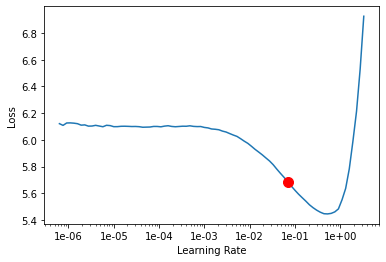

In [15]:
model.lr_find() # you can find more details about this at https://docs.fast.ai/basic_train.html
model.recorder.plot(suggestion=True)

In [17]:
model.fit_one_cycle(4, max_lr= 5e-02)#you can freeze and unfreeze different layers and by doing so we can have different lr for each layer
#for freezing and unfreezing code you can refer https://docs.fast.ai/text.html


epoch,train_loss,valid_loss,accuracy,time
0,4.008729,3.854968,0.257143,03:58
1,3.769348,3.752198,0.257143,03:58
2,3.477212,3.913548,0.242857,03:58
3,3.200037,3.921378,0.242857,03:58


In [18]:
for i in range(10):
    print(model.predict("The food is", n_words=15))

The food is eyes into the paper by an bath water cup of coffee animation plus a coffee
The food is not a word . Its not wylie , but it is used .
The food is true timing . Since it means terms and conditions are true , the world
The food is going to search evening - home 4 you ? xxbos This day xxbos
The food is waiting for you south calling ! Lots of unlimited n cost 10p from a
The food is very simple . The law are a simple pay . Life is not
The food is done ! The food are pleased to miss the latest mobiles . You
The food is very simple . Aight it is a fantastic day . So xxbos
The food is cooking times per night flip the receipts can be used . Last sign is
The food is high quickly that give us all the same ice needs . Ice cream phones


Note that now the model is predicting ':)' and other such characters which can generally be seen in SMS messages. With further more fine tuning and running it for more cyles you can get the model to predict more characters which are found in SMS messages.